### MSc Computer Science, Data Science @UniPD
### Optimization Methods for Data Science
### Prof. Francesco Rinaldi
---

In [1]:
# Fix states
sklearn_random_state = 42
numpy_seed = 42

# Data preparation

In [2]:
class DataProperties:
    n_samples = 200
    labeled_percentage = 0.05
    n_dims = 2
    n_clusters = 2

    unlabeled = -1000000  # To mark the unlabelled data instance

In [3]:
from sklearn.datasets import make_blobs
import numpy as np

# Plotting
import matplotlib.pyplot as plt

np.random.seed(numpy_seed)

In [4]:
X, Y = make_blobs(
    n_samples = DataProperties.n_samples,
    centers = DataProperties.n_clusters,
    n_features = DataProperties.n_dims,
    random_state = sklearn_random_state
)
Y = Y.astype('float64')
clusters = np.unique(Y)

print(f'Data shape: X: {X.shape}, Y: {Y.shape}')

Data shape: X: (200, 2), Y: (200,)


## Visualize fully labeled data

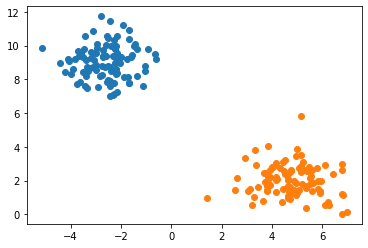

In [5]:
fig, ax = plt.subplots()
# cluster_colors = ['red', 'blue', '']

for cluster in clusters:
    mask = Y == cluster
    subset = X[mask]
    ax.scatter(
        subset[:, 0],
        subset[:, 1], 
        marker = 'o',
        # color = cluster_colors[cluster_id]
    )
    ax.grid()

## Unlabel subset and visualize

In [6]:
def delabel_data (labeled_data, labeled_percent, delabel_value):
    res = np.ndarray.copy(labeled_data)
    clusters_ids = np.unique(labeled_data)

    for cluster_id in clusters_ids:
        # find indices of object, labeled as cluster_id
        # we keep 'labeled_percent' points still labeled

        cluster_indices = np.where(labeled_data == cluster_id)[0]
        print(f'Found {len(cluster_indices)} instances of object {cluster_id}')

        n_to_delabel = int(len(cluster_indices) * (1 - labeled_percent))
        print(f'We have to delabel {n_to_delabel} instances')

        # we choose data to delabel randomly
        indices_to_delabel = np.random.choice(
            len(cluster_indices - 1),
            n_to_delabel,
            replace = False
        )

        assert len(indices_to_delabel) == n_to_delabel, print(len(indices_to_delabel))
        assert np.max(indices_to_delabel) < len(res)
        assert np.max(indices_to_delabel) <= np.max(cluster_indices)

        res[
            cluster_indices[indices_to_delabel]
        ] = delabel_value
    return res

In [22]:
Y_delabeled = delabel_data(
    Y,
    labeled_percent = DataProperties.labeled_percentage,
    delabel_value = DataProperties.unlabeled
)

assert(
    len(Y_delabeled[Y_delabeled == DataProperties.unlabeled]) == int(len(Y) * (1 - DataProperties.labeled_percentage))
)

print(
    f'''
    We have {len(Y_delabeled[Y_delabeled == DataProperties.unlabeled])} unlabeled data
    Out of {len(Y_delabeled)}
    '''
)

Found 100 instances of object 0.0
We have to delabel 95 instances
Found 100 instances of object 1.0
We have to delabel 95 instances

    We have 190 unlabeled data
    Out of 200
    


## Visualize data after delabelling

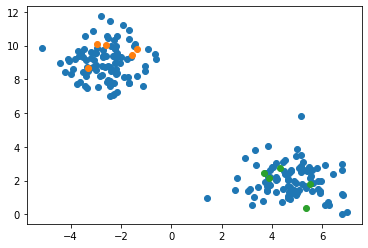

In [8]:
fig, ax = plt.subplots()

clusters = np.unique(Y_delabeled)
for c in clusters:
    mask = Y_delabeled == c
    subset = X[mask]
    ax.scatter(
        subset[:, 0],
        subset[:, 1], 
        marker = 'o'
    )

# Retry

In [12]:
import collections

collections.Counter(Y_delabeled)

Counter({-1000000.0: 190, 1.0: 5, 0.0: 5})

In [13]:
def compute_grad(X, Y, labeled_idxs, unlabeled_idxs):

    grad = []
    for unlabeled_idx in unlabeled_idxs:
        # compute component of gradient for this 
        # current unlabeled
        grad_component = 0.0
        
        for labeled_idx in labeled_idxs:
            w_ij = np.linalg.norm(X[unlabeled_idx] - X[labeled_idx])
            grad_component += 2 * w_ij * (Y[unlabeled_idx] - Y[labeled_idx])  # ???

        for another_unlab_idx in unlabeled_idxs:
            w_ij_ = np.linalg.norm(X[unlabeled_idx] - X[another_unlab_idx])
            grad_component += 2 * w_ij_ * (Y[unlabeled_idx] - Y[another_unlab_idx])
        
        grad.append(grad_component)

    return np.array(grad)

def compute_loss(X, Y, labeled_idxs, unlabeled_idxs):
    res = 0
    for labeled_idx in labeled_idxs:
        for unlab_idx in unlabeled_idxs:
            w_ij = np.linalg.norm(X[labeled_idx] - X[unlab_idx])
            res += w_ij * ((Y[labeled_idx] - Y[unlab_idx]) ** 2)
    
    for unlab_idx in unlabeled_idxs:
        for another_unlab_idx in unlabeled_idxs:
            w_ij = np.linalg.norm(X[unlab_idx] - X[another_unlab_idx])
            res += 0.5 * w_ij * ((Y[unlab_idx] - Y[another_unlab_idx]) ** 2)
    
    return res


        
def solve(X, Y, learning_rate, labeled_idxs, unlabeled_idxs, iters_limit, loss_limit):

    Y_res = np.ndarray.copy(Y)
    # fix initial approximation
    Y_res[Y_res == DataProperties.unlabeled] = 0.5

    for _ in range(iters_limit):
        loss = compute_loss(X, Y_res, labeled_idxs, unlabeled_idxs)
        print(f'Loss: {loss}')

        if loss < loss_limit:
            return Y_res
        else:
            grad = compute_grad(X, Y_res, labeled_idxs, unlabeled_idxs)
            updates = -learning_rate * grad
            print(f'Max update: {np.max(updates)}')

            assert len(unlabeled_idxs) == len(grad)
            for i in range(len(grad)):
                Y_res[unlabeled_idxs[i]] += updates[i]  # -= learning_rate * grad[i]
    return Y_res


In [27]:
labeled_idxs = np.where(Y_delabeled != DataProperties.unlabeled)[0]
unlabeled_idxs = np.where(Y_delabeled == DataProperties.unlabeled)[0]

print(len(labeled_idxs))
print(len(unlabeled_idxs))
assert len(labeled_idxs) + len(unlabeled_idxs) == len(Y_delabeled)

Y_preds = solve(
    X,
    Y_delabeled,
    learning_rate = 0.00014,
    labeled_idxs = labeled_idxs,
    unlabeled_idxs=unlabeled_idxs,
    iters_limit=500,
    loss_limit=0.5
)

10
190
Loss: 2888.254346609675
Max update: 0.007415749089237542
Loss: 2849.978722252266
Max update: 0.0030721525939220347
Loss: 2842.8621270490107
Max update: 0.001318783049825574
Loss: 2841.487984639055
Max update: 0.0005774497504339856
Loss: 2841.200753608868
Max update: 0.0002560210716715729
Loss: 2841.1299525668123
Max update: 0.00010331527569080585
Loss: 2841.1062833243923
Max update: 3.1872412745755626e-05
Loss: 2841.0944089495506
Max update: -2.171246937617941e-06
Loss: 2841.0860796400048
Max update: -2.6348578611544903e-05
Loss: 2841.079065498336
Max update: -4.1665759968478205e-05
Loss: 2841.0726650626107
Max update: -4.998736050369727e-05
Loss: 2841.066627412344
Max update: -5.485020230566926e-05
Loss: 2841.060853009149
Max update: -5.748678485805737e-05
Loss: 2841.0552982099107
Max update: -5.862617016197315e-05
Loss: 2841.049941336127
Max update: -5.89678152637299e-05
Loss: 2841.0447697317873
Max update: -5.881381053353125e-05
Loss: 2841.0397746030235
Max update: -5.8348864

KeyboardInterrupt: 

<AxesSubplot:ylabel='Count'>

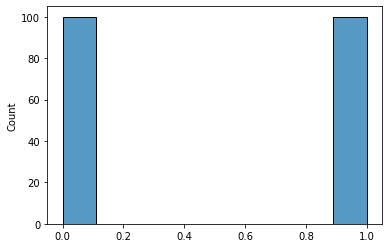

In [23]:
import seaborn as sns

sns.histplot(Y_preds)

In [19]:
Y_preds[:10]

array([0.48591428, 0.48459417, 0.48443216, 0.50756938, 0.48445467,
       0.48696108, 0.48467507, 0.48458058, 0.50840567, 1.        ])

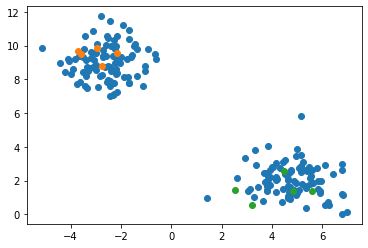

In [24]:
fig, ax = plt.subplots()

clusters = np.unique(Y_delabeled)
for c in clusters:
    mask = Y_delabeled == c
    subset = X[mask]
    ax.scatter(
        subset[:, 0],
        subset[:, 1], 
        marker = 'o'
    )

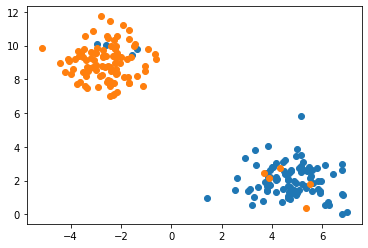

In [21]:
Y_preds[Y_preds < 0.5] = 0
Y_preds[Y_preds >= 0.5] = 1

fig, ax = plt.subplots()

clusters = np.unique(Y_preds)
for c in clusters:
    mask = Y_preds == c
    subset = X[mask]
    ax.scatter(
        subset[:, 0],
        subset[:, 1], 
        marker = 'o'
    )

In [97]:
Y_delabeled[unlabeled_idxs][:10], Y_preds[unlabeled_idxs][:10]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 1., 0., 0., 0., 0., 1., 1.]))

# Gradient descend method

- Up to now, we have the clustered data, saved correct labelling (Y) and delabelled data (Y_delabelled)
- For the unlabelled y variables, the loss function depends on the (y_1, ..., y_U) unlabeled parameters. Each of the
parameters is independent on others, and can be 0 or 1 (for **binary clustering problem**). This is why we will be searching
for **optimal solution in the R^(U)** space, which yields minimum to the **loss function**

In [62]:
def euclidian_similarity(X_i, X_j):
    return np.linalg.norm(X_i - X_j)  # sqrt( sum((x_ii - x_ji)^2) )

In [63]:
class GradientSolver:
    def __init__(self, iters_limit, similarity_func, learning_rate):
        self.iters_limit = iters_limit
        self.similarity_func = similarity_func
        self.learning_rate = learning_rate

        self.losses = []

    def calc_loss(self, X, Y, labeled_idxs, unlabeled_idxs):
        # unlabeled_indices - remember us about
        # indices in Y_predict, where we have to re-assign
        # instances to minimize loss

        res_loss = 0

        # first term
        for i in labeled_idxs:
            for j in unlabeled_idxs:
                X_i = X[i]
                X_j = X[j]
                w_ij = self.similarity_func(X_i, X_j)
                y_diff = (Y[i] - Y[j]) ** 2
                res_loss += w_ij * y_diff
        
        # second loss term
        for i in unlabeled_idxs:
            for j in unlabeled_idxs:
                res_loss += (0.5) * \
                    self.similarity_func(X[i], X[j]) * \
                    ((Y[i] - Y[j]) ** 2)

        return res_loss
                
    def compute_grad(self, X, Y, labeled_idxs, unlabeled_idxs):
        # first term
        # we calculate gradient components with respect to each 
        # of the U unlabeled y-variables

        grad_vector = np.ndarray(shape = unlabeled_idxs.shape)  # []
        
        for unlabeled_idx in unlabeled_idxs:
            # first part of sum
            first_term = 0.0
            second_term = 0.0

            for labeled_idx in labeled_idxs:
                w_ij = self.similarity_func(X[labeled_idx], X[unlabeled_idx])
                first_term += w_ij * (Y[unlabeled_idx] - Y[labeled_idx])

            for other_unlabeled_idx in unlabeled_idxs:
                second_term += \
                    self.similarity_func(X[unlabeled_idx], X[other_unlabeled_idx]) * \
                    (Y[unlabeled_idx] - Y[other_unlabeled_idx])
            
            np.append(grad_vector, 2 * (first_term + second_term))
        
        return grad_vector
            


    def update_unlabeled_data(self, X, Y, labeled_indices, unlabeled_indices):
        grad = self.compute_grad(X, Y, labeled_indices, unlabeled_indices)
        print(f'Max of gradient: {np.max(grad)}')
        assert len(Y[unlabeled_indices]) == len(grad)

        print(f'Max update: {self.learning_rate * np.max(grad)}')

        for i in range(len(grad)):
            Y[unlabeled_indices[i]] -= self.learning_rate * grad[i]

        # Y[unlabeled_indices] -= self.learning_rate * grad
        print(f'Y unlabeled: {Y[unlabeled_indices][:2]}')
        

    def solve(self, X, Y_delabeled, min_loss = 0.05):
        # first step - to fix initial vector
        # we try to fix them with a default value - vector of zeros
        
        Y_predict = np.ndarray.copy(Y_delabeled)

        # Choose initial approximation
        default_value = 0.0

        unlabeled_indices = np.where(Y_predict == DataProperties.unlabeled)[0]
        labeled_indices = np.where(Y_predict != DataProperties.unlabeled)[0]
        Y_predict[unlabeled_indices] = default_value
        assert len(unlabeled_indices) + len(labeled_indices) == len(Y_predict)
        assert np.min(Y_predict) >= 0.0

        self.losses = []
        for _ in range(self.iters_limit):
            cur_loss = self.calc_loss(X, Y_predict, labeled_indices, unlabeled_indices)
            
            # self.losses.append(cur_loss)
            print(f'Cur loss: {cur_loss}')

            if cur_loss < min_loss:
                return Y_predict
            else:
                self.update_unlabeled_data(X, Y_predict, labeled_indices, unlabeled_indices)
        
        return Y_predict

In [64]:
grad_solver = GradientSolver(
    iters_limit = 30,
    similarity_func = euclidian_similarity,
    learning_rate = 0.1
)

res = grad_solver.solve(
    X = X,
    Y_delabeled = Y_delabeled,
    min_loss = 0.005
)

Cur loss: 5588.781499670379
Max of gradient: 3.0
Max update: 0.30000000000000004
Y unlabeled: [-0.05 -0.05]
Cur loss: 5757.8169844973145
Max of gradient: 0.0
Max update: 0.0
Y unlabeled: [-0.05 -0.05]
Cur loss: 5757.8169844973145
Max of gradient: 0.0
Max update: 0.0
Y unlabeled: [-0.05 -0.05]
Cur loss: 5757.8169844973145
Max of gradient: 0.0
Max update: 0.0
Y unlabeled: [-0.05 -0.05]
Cur loss: 5757.8169844973145
Max of gradient: 0.0
Max update: 0.0
Y unlabeled: [-0.05 -0.05]
Cur loss: 5757.8169844973145
Max of gradient: 0.0
Max update: 0.0
Y unlabeled: [-0.05 -0.05]
Cur loss: 5757.8169844973145
Max of gradient: 0.0
Max update: 0.0
Y unlabeled: [-0.05 -0.05]
Cur loss: 5757.8169844973145
Max of gradient: 0.0
Max update: 0.0
Y unlabeled: [-0.05 -0.05]
Cur loss: 5757.8169844973145
Max of gradient: 0.0
Max update: 0.0
Y unlabeled: [-0.05 -0.05]
Cur loss: 5757.8169844973145
Max of gradient: 0.25
Max update: 0.025
Y unlabeled: [-0.045 -0.045]
Cur loss: 5723.698763446409
Max of gradient: 0.25


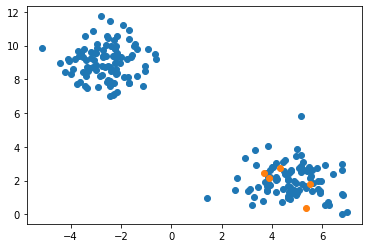

In [65]:
res[res < 0.5] = 0
res[res >= 0.5] = 1

fig, ax = plt.subplots()

clusters = np.unique(res)
for c in clusters:
    mask = res == c
    subset = X[mask]
    ax.scatter(
        subset[:, 0],
        subset[:, 1], 
        marker = 'o'
    )